In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
df = pd.read_csv("../data/penguins.csv")

In [3]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


## Exploratory data analysis

<AxesSubplot:xlabel='species', ylabel='count'>

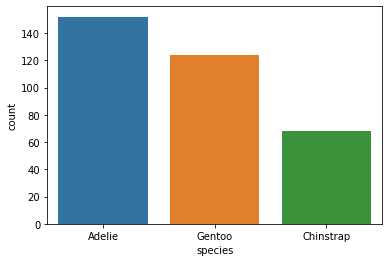

In [6]:
sns.countplot(x="species", data=df)

In [7]:
df.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

In [8]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,342.000000,342.000000,342.000000,342.000000,344.000000
mean,43.921930,17.151170,200.915205,4201.754386,2008.029070
std,5.459584,1.974793,14.061714,801.954536,0.818356
min,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,39.225000,15.600000,190.000000,3550.000000,2007.000000
50%,44.450000,17.300000,197.000000,4050.000000,2008.000000
75%,48.500000,18.700000,213.000000,4750.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


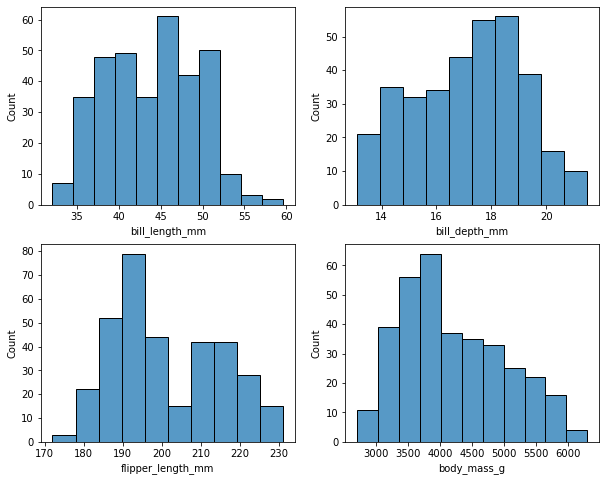

In [13]:
num_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

plt.figure(figsize=(10, 8))
for i, col in enumerate(num_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col])

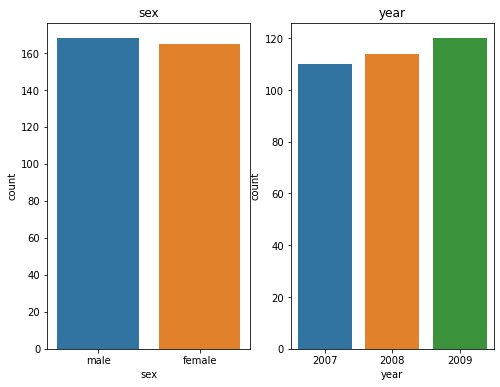

In [22]:
cat_cols = ['sex', 'year']

plt.figure(figsize=(8, 6))

for i, col in enumerate(cat_cols):
    plt.subplot(1, 2, i+1)
    plt.title(col)
    sns.countplot(x=col, data=df)

<AxesSubplot:>

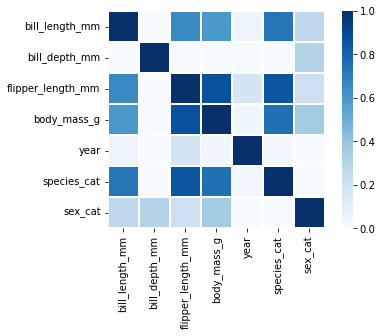

In [25]:
from sklearn.preprocessing import LabelEncoder

enc_species = LabelEncoder()
df['species_cat'] = enc_species.fit_transform(df.species)

enc_sex = LabelEncoder()
df['sex_cat'] = enc_sex.fit_transform(df.sex)

corr = df.corr()
sns.heatmap(corr, vmin=0, vmax=1, linewidths=2, square=True, cmap='Blues')

## Baseline model